# STEP 1 - Problem Definition:
### Our Goal was to build a Transformer Model That is training on text data and produces text output based on the user input.

# STEP 2 - Data Exploration And Analysis

### Exploring The Data To Make More Sense Of What Is Going On And What type of data we have.

In [ ]:
import pandas as pd
import os
import gc
import glob
import math
import random
from tqdm import tqdm
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as F
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.optim as optim
import heapq
from typing import Dict, List, Tuple

In [ ]:
# Mounting The Revelent Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Directory List
import os
os.listdir('/content/drive/MyDrive/')

['Khaya Philosophies',
 'Khaya Trading University',
 'Car_design_files.zip',
 'SAHARA',
 'AMAHLE',
 'SONO EZEZIMOTO',
 'Sonosezimoto web 1.zip',
 'Important',
 'Personal Brand',
 'Curriculum',
 'Jupyter',
 'Colab Notebooks',
 'Assignment.gdoc',
 'Copy of Loan Approval (Classification Deep Neural Network).ipynb',
 'Attention is All You Need_250224_134635.pdf',
 'tokenizer',
 'AIMLFinalProject ',
 'FinalProject',
 'Transformer_Training_Dataset(1).txt',
 'vocab.json',
 'merges.txt',
 'tokenizer.json',
 'Cleaned_Transformer_Training_Dataset.txt']

In [ ]:
# Selecting File Dataset and Reading File And Converting it into a DataFrame
file_path = "/content/drive/MyDrive/Transformer_Training_Dataset(1).txt"

with open(file_path, 'r') as file:
    lines = file.readlines()

df = pd.DataFrame(lines, columns=['text'])

In [ ]:
# Printing The Columns Of The DataFrame
df.head()

,text
0,"Robert W: Hi, I�m Rob, Director of Research at..."
1,\n
2,Miles�s research has been supported by the Nat...
3,\n
4,Miles Brundage: [00:00:30] Thanks for having m...


In [ ]:
# Describing The DataFrame
df.describe()

,text
count,2115432
unique,2084506
top,\n
freq,25160


In [ ]:
# Shape Of Our DataFrame
print(df.shape)

(2115432, 1)


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2115432 entries, 0 to 2115431
Data columns (total 1 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   text    object
dtypes: object(1)
memory usage: 16.1+ MB
None


In [ ]:
# Checking Number Of Null Values
print(df.isnull().sum())

text    0
dtype: int64


In [ ]:
# Calculating The Text Length Distribution Of Each Line
df['text_length'] = df['text'].str.len()

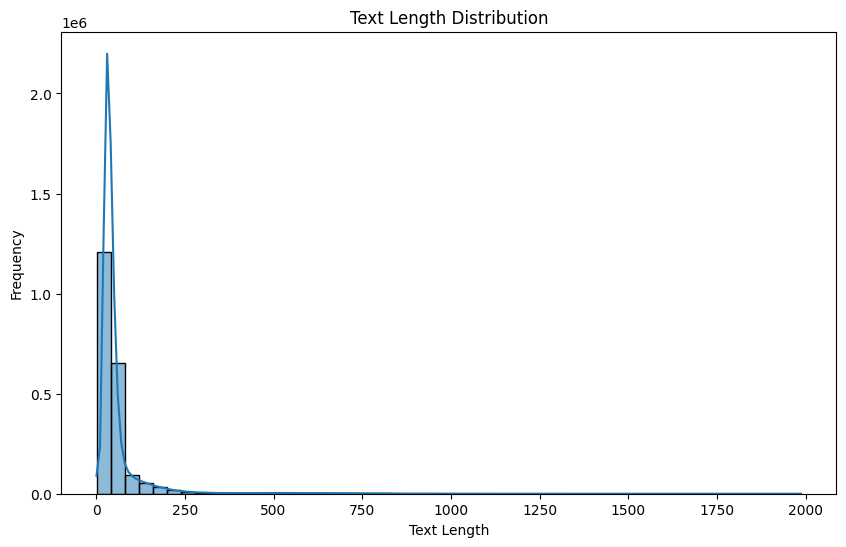

In [ ]:
# Plotting The Text Length Distribution Of Each Line
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

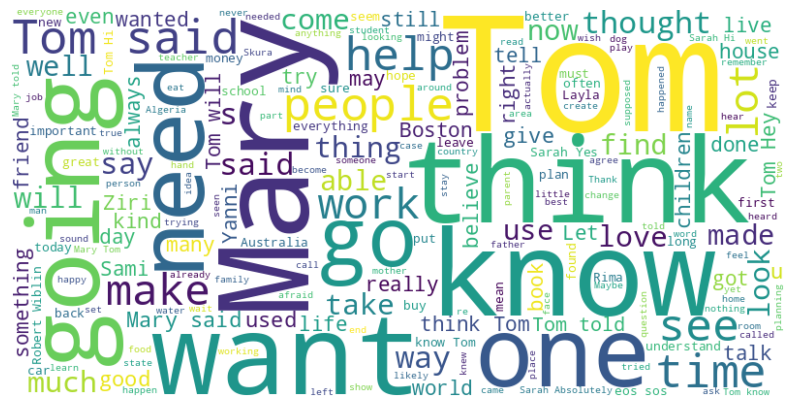

In [ ]:
# Displaying The Most Frequent Words In Our Dataset
from wordcloud import WordCloud

# Assuming 'df' is your DataFrame containing the text data, Create all_words from your DataFrame
all_words = ' '.join(df['text']).split()

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# STEP 2 - Data Cleaning

### Exploring The Data To Make More Sense Of What Is Going On And What type of data we have.

In [ ]:
# Tokenizing and Cleaning Text
from collections import Counter
import re

# Removing Special Characters And Extra Spaces
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
all_words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(all_words)

# Display the most common words
print(word_freq.most_common(10))

[('the', 877731), ('to', 745946), ('i', 605577), ('tom', 541601), ('a', 507697), ('that', 464313), ('and', 418215), ('you', 401043), ('of', 392047), ('is', 320802)]


In [ ]:
# Verify the cleaning
df.head()

,text,text_length,cleaned_text
0,"Robert W: Hi, I�m Rob, Director of Research at...",404,robert w hi i m rob director of research at 80...
1,\n,1,
2,Miles�s research has been supported by the Nat...,187,miles s research has been supported by the nat...
3,\n,1,
4,Miles Brundage: [00:00:30] Thanks for having m...,49,miles brundage 00 00 30 thanks for having me


In [ ]:
# Saving the cleaned text to a new file
cleaned_file_path = '/content/drive/MyDrive/Cleaned_Transformer_Training_Dataset.txt'
df['cleaned_text'].to_csv(cleaned_file_path, index=False, header=False)

# STEP 3 - Model Development

### Building a Decoder Only Model taht contains Embedding Layers, Positional Encoding, Multi-Head Self-Attention with casual masking, Feed Forward Networks, Layer Normalization with defined Hyperparameters

In [ ]:
!pip install torch

In [ ]:
import os
import gc
import glob
import math
import random
from tqdm import tqdm
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.functional as F
from transformers import AutoTokenizer
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.optim as optim
import heapq
from typing import Dict, List, Tuple

In [ ]:
!pip install torchinfo -q

In [ ]:
from torchinfo import summary

In [ ]:
print("PyTorch Version: ", torch.__version__)

PyTorch Version:  2.5.1+cu124


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import maths
from transformers import AutoTokenizer

# A Feed-Forward Multi-Layer Perceptron (MLP) used in transformer architectures
class FeedForwardMLP(nn.Module):
    def __init__(self, embed_dim, dropout_rate, device, dtype):
        # Constructor
        super().__init__()
        # A fully connected layer that expands the input size (embed_dim) to 4 times its size (embed_dim * 4)
        self.linear1 = nn.Linear(embed_dim, embed_dim * 4, device=device, dtype=dtype)
        # A second fully connected layer that projects the intermediate representation back to the original embedding size (embed_dim).
        self.linear2 = nn.Linear(embed_dim * 4, embed_dim, device=device, dtype=dtype)
        # Applies dropout to reduce overfitting by randomly setting a fraction of input units to zero during training.
        self.dropout = nn.Dropout(dropout_rate)

    # Forward Pass (forward method)
    def forward(self, x):
        # Applies the first linear transformation (embed_dim → 4 * embed_dim).
        x = self.linear1(x)
        # Applies the ReLU (Rectified Linear Unit) activation function, introducing non-linearity.
        x = F.relu(x)
        # Applies the second linear transformation (4 * embed_dim → embed_dim), reducing the expanded dimension back to the original embedding size.
        x = self.linear2(x)
        # Applies dropout to the output, randomly deactivating some neurons during training to prevent overfitting.
        x = self.dropout(x)
        # Returns the processed tensor
        return x


# A Positional Encoding module for a transformer model, Inherits from nn.Module, making it a PyTorch module.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, context_length, dtype, device):
        # Constructor
        super().__init__()
        # Creates a zero matrix of shape (context_length, embed_dim), which will store positional encodings.
        pe = torch.zeros(context_length, embed_dim)
        # Creates a column vector representing positions: [0, 1, 2, ..., \text{context_length} - 1]
        position = torch.arange(0, context_length, dtype=dtype).unsqueeze(1)
        # Computes the frequency scaling factor for different embedding dimensions.
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=dtype) * (-math.log(10000.0) / embed_dim))
        # Apply Sinusoidal Functions, Sin for even indices, Cos for odd indices, provides smooth positional encoding with unique values for each position, while also allowing extrapolation beyond training sequences.
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # Register Buffer,
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    # Forward Pass
    def forward(self, x):
        return self.pe[:, :x.size(1)]


# FullEmbedding class, which combines word embeddings and positional encodings.
class FullEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, context_length, dtype, device):
        # Constructor
        super().__init__()
        # Embedding Layer, Creates an embedding lookup table of shape (vocab_size, embed_dim), The embeddings are trainable parameters, meaning the model updates them during training.
        self.embedding = nn.Embedding(vocab_size, embed_dim, dtype=dtype, device=device)
        # Positional Encoding Layer, This will generate fixed sinusoidal positional encodings for sequence positions.
        self.positional_encoding = PositionalEncoding(embed_dim, context_length, dtype=dtype, device=device)

    # Forward Pass, Defines how input tokens are transformed into embeddings.
    def forward(self, x):
        # Convert Tokens to Embeddings, The input x is an integer tensor of shape (batch_size, sequence_length), containing token indices.
        x = self.embedding(x)
        # Add Positional Encoding, Retrieves the corresponding positional encodings and adds them to the word embeddings.
        x = x + self.positional_encoding(x)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, num_heads, embed_dim, dropout_rate, dtype, device):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=dropout_rate, batch_first=True, dtype=dtype, device=device)
        self.mlp = FeedForwardMLP(embed_dim=embed_dim, dropout_rate=dropout_rate, device=device, dtype=dtype)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        seq_len = x.shape[1]
        attn_mask = torch.triu(torch.full((seq_len, seq_len), float('-inf'), device=x.device), diagonal=1)
        attn_output, _ = self.attn(x, x, x, attn_mask=attn_mask)
        x = self.norm1(attn_output + x)
        output = self.mlp(x)
        output = self.norm2(output + x)
        return output

class Decoder(nn.Module):
    def __init__(self, num_layers, num_heads, embed_dim, vocab_size, context_length, dropout_rate, device, dtype):
        super().__init__()
        self.embedding = FullEmbedding(vocab_size, embed_dim, context_length, dtype=dtype, device=device)
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(num_heads, embed_dim, dropout_rate, device=device, dtype=dtype) for _ in range(num_layers)]
        )
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        for dec_layer in self.decoder_layers:
            x = dec_layer(x)
        return x

class DecoderOnlyModel(nn.Module):
    def __init__(self, num_layers, num_heads, embed_dim, context_length=100, dropout_rate=0.1, device='cpu', dtype=torch.float32, model_name="DecoderOnlyModel", with_encoder=False):
        super().__init__()
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.context_length = context_length
        self.vocab_size = self.tokenizer.vocab_size
        self.dropout_rate = dropout_rate
        self.device = device
        self.dtype = dtype

        self.decoder = Decoder(self.num_layers, self.num_heads, self.embed_dim, self.vocab_size, self.context_length, self.dropout_rate, self.device, self.dtype)
        self.final_linear = nn.Linear(self.embed_dim, self.vocab_size, dtype=self.dtype)

    def forward(self, x):
        x = self.decoder(x)
        logits = self.final_linear(x)
        return logits if self.training else F.softmax(logits, dim=-1)

    @torch.no_grad()
    def generate(self, inputs=None, max_output=None):
        self.eval()
        max_output = (max_output or self.context_length) - 3

        if inputs is None:
            return None, None

        x = torch.tensor([self.tokenizer.encode(inputs)], device=self.device)

        output = x
        for _ in range(max_output):
            probs = self(output)
            next_word_probs = probs[:, -1, :]
            next_word = torch.argmax(next_word_probs, dim=-1, keepdim=True)
            if next_word.item() == self.tokenizer.eos_token_id:
                break
            output = torch.cat([output, next_word], dim=1)
        text = self.tokenizer.decode(output[0])
        return text, output

# STEP 4 - Inference

### We made predictions by giving an input to test the model with Hyperparameters.

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
model_name = "SimpleLangugeProcessor-Demo"

num_layers = 3
num_heads = 8
embed_dim = 512
dropout_rate = 0.1

context_length = 500
with_encoder = False
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model_instance = DecoderOnlyModel(
    num_layers=num_layers,
    num_heads=num_heads,
    embed_dim=embed_dim,
    dropout_rate=dropout_rate,
    with_encoder=with_encoder,
    device=device,
    model_name=model_name
)
model_instance = model_instance.to(device)

In [ ]:
prompt = "Hello there, how are you today???!"
output, tokens = model_instance.generate(prompt, max_output=50)
print(output)
# print(tokens)

Hello there, how are you today???!�sam regimecipled Fame sure BoshExcellentFFENmary veterinarian powerfulExcellent clansoriekillinghandedlymares neverenth Truthvernment temptationCustomer Three Guides halting Stealth dressedalearsitysoft Eddie temptationCustomer fleetsdkwhel monthly Act made Pablouez rankedston oy


In [ ]:
context_input = torch.tensor([model_instance.tokenizer.encode(prompt)]).to(model_instance.device)
# prompt_input = torch.tensor([[model_instance.tokenizer.eos_token_id]]).to(model_instance.device) # This is not needed for DecoderOnlyModel


# Reshape input_data for DecoderOnlyModel
input_data = context_input # Pass the input directly, not as a dictionary

summary(model_instance, input_data=input_data, device=model_instance.device)

Layer (type:depth-idx)                        Output Shape              Param #
DecoderOnlyModel                              [1, 9, 50257]             --
├─Decoder: 1-1                                [1, 9, 512]               --
│    └─FullEmbedding: 2-1                     [1, 9, 512]               --
│    │    └─Embedding: 3-1                    [1, 9, 512]               25,731,584
│    │    └─PositionalEncoding: 3-2           [1, 9, 512]               --
│    └─Dropout: 2-2                           [1, 9, 512]               --
│    └─ModuleList: 2-3                        --                        --
│    │    └─DecoderLayer: 3-3                 [1, 9, 512]               3,152,384
│    │    └─DecoderLayer: 3-4                 [1, 9, 512]               3,152,384
│    │    └─DecoderLayer: 3-5                 [1, 9, 512]               3,152,384
├─Linear: 1-2                                 [1, 9, 50257]             25,781,841
Total params: 60,970,577
Trainable params: 60,970,577
Non-

# Training Model

### We will now train the model to be able to produce valid output based on the training data.

In [ ]:
epochs = 500
learning_rate = 1e-5
batch_size = 4

In [ ]:
class LanguageModellingDataset(Dataset):
    def __init__(self, text_src, tokenizer, context_length=100, stride=50):
        self.tokenizer = tokenizer
        self.text_src = text_src
        self.context_length = context_length
        self.stride = stride  # How much to slide the window

        if isinstance(text_src, str) and os.path.isfile(text_src):
            with open(text_src, 'r') as f:
                self.text_src = f.read()  # Read the whole file as one string
        elif isinstance(text_src, str): # If text_src is already a string
            self.text_src = text_src
        else:
            raise TypeError("text_src must be a string or a path to a text file.")

        self.tokenized_text = self.tokenizer.encode(self.text_src, add_special_tokens=False) # Tokenize once
        self.chunks = self._chunk_tokens()

    def _chunk_tokens(self):
        chunks = []
        for i in range(0, len(self.tokenized_text) - self.context_length, self.stride):
            chunk = self.tokenized_text[i:i + self.context_length]
            chunks.append(chunk)
        return chunks

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        chunk = self.chunks[idx]
        input_ids = torch.tensor(chunk) # Convert to tensor directly
        attention_mask = torch.ones_like(input_ids) # Create attention mask of 1s

        # Shift inputs for Autoregressive target labels
        labels = input_ids.clone()
        labels[:-1] = input_ids[1:]  # Shift left
        labels[-1] = self.tokenizer.eos_token_id  # Ignore last token

        # Ensure labels are within the valid vocabulary range
        labels[labels >= self.tokenizer.vocab_size] = self.tokenizer.pad_token_id # self.tokenizer.pad_token_id  # Ignore last token # Ignore last token

        return { "input_ids": input_ids,  "attention_mask": attention_mask,  "labels": labels}

In [ ]:
# # Directory List
# import os
# os.listdir('/content/drive/MyDrive/')

# # Selecting File Dataset and Reading File And Converting it into a DataFrame
# file_path = "/content/drive/MyDrive/Transformer_Training_Dataset(1).txt"

# with open(file_path, 'r', encoding="utf-8") as file:
#     pretraining_text_src = file.read()

In [ ]:
pretraining_text_src = """
Hello there, how are you today? I'm doing great, thank you! How about you? What is your name? My name is Chatbot.
Nice to meet you! Can you help me with my homework? Of course! What do you need help with? The weather is nice today, isn't it?
Yes, it's a beautiful day outside! The sun is shining and there's a gentle breeze. Perfect weather for a walk or picnic. Do you enjoy outdoor activities?

I love spending time outside! What's your favorite outdoor activity? I enjoy hiking and photography. The combination lets me explore nature while capturing beautiful moments. Have you ever tried nature photography?

That sounds fascinating! I'd love to learn more about photography. What kind of camera would you recommend for a beginner? There are many options available, from smartphone cameras to DSLRs. It really depends on your goals and budget. Would you like me to explain the different types?

Yes, please tell me more about cameras! Well, smartphones these days have excellent cameras and are great for learning composition. Entry-level DSLRs offer more control but require more learning. Mirrorless cameras are becoming increasingly popular too. What's your budget range?

Tell me a joke while I think about it. Why did the scarecrow win an award? Because he was outstanding in his field! That's a classic! Here's another one: Why don't scientists trust atoms? Because they make up everything!

Those are quite funny! Speaking of science, what is your favorite scientific discovery? I find the theory of relativity fascinating. Einstein's work changed our understanding of space and time completely. What aspects of science interest you most?

I'm actually more interested in history. What's the capital of France? The capital of France is Paris. It's a city with an incredible history! Did you know the Eiffel Tower was originally meant to be temporary? It was built for the 1889 World's Fair and was supposed to be dismantled after 20 years.

That's interesting! I'm getting hungry though. How do I cook pasta? Boil water, add salt, and cook the pasta until it's al dente. The key is using plenty of water and salting it well. Some people add olive oil to prevent sticking, but that's actually not necessary. The most important thing is stirring occasionally and testing for doneness.

Thanks for the cooking tips! It makes me think about the meaning of life. What do you think about that? The meaning of life is subjective, but many say it's about finding happiness and fulfillment. Some find it in relationships, others in achievement or creativity. Philosophy has grappled with this question for millennia. What brings meaning to your life?

That's quite deep! Let's lighten things up - what's your favorite color? I like blue. What about you? I like green. Both are colors found abundantly in nature! Blue like the ocean and sky, green like forests and meadows. Colors can have such a strong effect on our mood and emotions. Do you find certain colors affect how you feel?

Definitely! Speaking of learning new things, what's the best way to learn a new language? Immersion and practice are key. Try speaking with native speakers and don't be afraid to make mistakes. Regular practice, even just 15 minutes a day, can make a huge difference. Language learning apps can be helpful, but nothing beats real conversation. Have you tried learning any foreign languages?

Yes, I'm studying Spanish! That's wonderful! Spanish is such a widely spoken language with rich cultural heritage. Do you watch Spanish movies or listen to Spanish music as part of your learning? That can really help with comprehension and pronunciation.

Actually, that reminds me - is there life on other planets? That's a question scientists are still trying to answer. There's no definitive proof yet, but it's certainly a possibility. The discovery of exoplanets and potential biosignatures has made this question more intriguing than ever. The James Webb Space Telescope is helping us learn more about distant worlds. What do you think about the possibility of alien life?

That's fascinating! But let's talk about something more immediate - what's the latest news? I'm still learning about current events. You can check a news website for the most up-to-date information. It's important to stay informed while being critical of sources. How do you usually get your news?

I prefer reading news websites. Speaking of reading, I love baking! How do I bake a cake? There are many cake recipes online. Find one that looks good to you and follow the instructions carefully. The key to good baking is precise measurements and following the recipe exactly. Would you like a specific recipe recommendation?

Yes, please! Well, a classic vanilla cake is a great place to start. But first, what's the weather like tomorrow? You can check a weather app or website for a forecast. Weather can affect baking - humidity levels can impact how ingredients behave. Are you planning to bake tomorrow?

Maybe! By the way, are you a robot? I am a language model, trained on a massive dataset of text. This brings up interesting questions about artificial intelligence and consciousness. What are your thoughts on AI?

That's interesting - what is artificial intelligence? Artificial intelligence is a field of computer science focused on creating machines that can perform tasks that typically require human intelligence. This includes things like understanding language, recognizing patterns, and making decisions. The field has made remarkable progress in recent years. Are you interested in AI development?

That's interesting. Tell me more. I can share information about many topics. What are you interested in? AI has applications in healthcare, education, environmental protection, and many other fields. Each application brings both opportunities and challenges. What aspects of AI interest you most?

Actually, let's talk about something else. Do you like music? Yes, I enjoy discussing music. What kind of music do you like? I can discuss various genres and their history. From classical to jazz, rock to hip-hop, each genre has its own unique development and cultural impact. What's your favorite genre?

I like rock music! What's your favorite movie? I don't have personal preferences like favorite movies, but I can discuss various films and their impact on culture and society. Would you like to explore different film genres or specific movies that have influenced cinema?

That would be great. Many classic films have shaped how we tell stories today. From silent films to modern blockbusters, cinema has evolved dramatically. Some particularly influential films include Citizen Kane for its innovative cinematography, 2001: A Space Odyssey for its groundbreaking special effects, and The Godfather for its storytelling. What kinds of movies do you enjoy most?

I love sci-fi! Have you traveled much? I haven't traveled physically, but I can discuss places all over the world. Every location has its own unique culture, history, and traditions. Where would you like to travel?

I'd love to visit Japan! Japan is fascinating with its blend of ancient traditions and modern technology. From historic temples to cutting-edge robotics, it offers unique experiences. The food culture is amazing too. What interests you most about Japan?

The food, definitely! Speaking of food, what's your favorite? As a language model, I don't eat, but I can discuss various cuisines and their cultural significance. Food is a wonderful way to explore different cultures. Every region has its own unique ingredients and cooking methods. What kinds of cuisine do you enjoy most?

I love Italian food! What's your favorite animal? I find many animals fascinating. Each species has unique adaptations and behaviors. From the problem-solving abilities of corvids to the social structures of elephants, the animal kingdom is full of wonders. What's your favorite animal?

I like dogs. They're very loyal and friendly. Yes, dogs are amazing companions! Their ability to understand human emotions and their unwavering loyalty make them special. Did you know dogs can understand over 150 words and can read human body language? Cats are great too.

Yes, cats are known for being independent and playful. They've been human companions for thousands of years. Each has their own unique personality. Do you have any pets?

Not yet, but I want one! What's your favorite color again? I said I like blue. What about you? I like green. Both colors appear frequently in nature. Color psychology suggests blue can have a calming effect, while green is often associated with growth and harmony. Do you find yourself drawn to these colors in your daily life?

Yes, I do! It's nice talking to you. It's been nice talking to you too. This conversation has covered so many interesting topics! I hope you've enjoyed exploring these different subjects. Goodbye! Goodbye! Take care and have a wonderful day!



Hello there, how are you today? I'm doing great, thank you! How about you? What is your name? My name is Chatbot.
Nice to meet you! Can you help me with my homework? Of course! What do you need help with? The weather is nice today, isn't it?
Yes, it's a beautiful day outside! Tell me a joke. Why did the scarecrow win an award? Because he was outstanding in his field!
What is the capital of France? The capital of France is Paris.
How do I cook pasta? Boil water, add salt, and cook the pasta until it's al dente. What is the meaning of life?
The meaning of life is subjective, but many say it's about happiness and fulfillment.  What's your favorite color?
I like blue. What about you? I like green.  What's the best way to learn a new language?  Immersion and practice are key.
Try speaking with native speakers and don't be afraid to make mistakes.  Is there life on other planets?
That's a question scientists are still trying to answer.  There's no definitive proof yet, but it's certainly a possibility.
What's the latest news?  I'm still learning about current events. You can check a news website for the most up-to-date information.
How do I bake a cake?  There are many cake recipes online.  Find one that looks good to you and follow the instructions carefully.
What's the weather like tomorrow? You can check a weather app or website for a forecast.  Are you a robot?
I am a language model, trained on a massive dataset of text.  What is artificial intelligence?
Artificial intelligence is a field of computer science focused on creating machines that can perform tasks that typically require human intelligence.
That's interesting. Tell me more.  I can share information about many topics. What are you interested in?  Do you like music?
Yes, I enjoy music. What kind of music do you like? I like a variety of genres.  What's your favorite movie?
I don't have personal preferences like favorite movies. I can tell you about popular movies if you'd like.
That would be great.  Many people enjoy movies like The Shawshank Redemption, The Godfather, and Pulp Fiction.
Have you traveled much?  I haven't traveled physically, but I have access to information about places all over the world.
Where would you like to travel?  I'd love to visit Kyoto, Japan.
Why?  It seems like a beautiful place with a rich history and culture, known for its temples, gardens, and traditional arts.
That sounds amazing.  Maybe someday I'll go there.  I hope you do!  Travel can be a very enriching experience.
What's your favorite food?  As a language model, I don't eat.
I can access information about different cuisines, though.  What's your favorite animal?
I find many animals fascinating.  What's your favorite animal?
I like dogs. They're very loyal and friendly.  Cats are great too.  Yes, cats are known for being independent and playful.
What's your favorite color again?  I said I like blue. What about you?  I like green.  Okay, I remember now.
It's nice talking to you.  It's been nice talking to you too.  Goodbye! Goodbye!  What's your favorite book?
I don't have personal preferences, but I can tell you about some popular books.  What kind of books do you enjoy?
I like science fiction and fantasy.  Have you read any books by authors like Isaac Asimov or J.R.R. Tolkien?
I'm familiar with their works.  They are very popular and influential authors in the science fiction and fantasy genres.  Many people enjoy their books.
What about you? Do you have any favorite authors?  I enjoy reading a variety of authors, both classic and contemporary.
That's great! Reading is a wonderful way to learn and explore new worlds.  What are some of your favorite things to learn about?
I'm interested in learning about science, history, and different cultures.  What about you?  What are you curious about?
I'm fascinated by technology and its impact on society.  That's a very important topic.  Technology is constantly evolving and shaping our world.
Do you think artificial intelligence will ever become more intelligent than humans?  That's a complex question that many experts are debating.
It's possible that AI could surpass human intelligence in certain areas, but it's also important to remember that human intelligence is multifaceted.
That's true.  Human intelligence involves creativity, emotions, and social interactions, which are difficult to replicate in machines.
Exactly.  AI is a powerful tool, but it's important to use it responsibly and ethically.  What are some of the ethical concerns surrounding AI?
One major concern is bias in AI algorithms.  If the data used to train an AI system is biased, the system may perpetuate or amplify those biases.
Another concern is job displacement.  As AI becomes more sophisticated, it may automate tasks that are currently performed by humans.
These are valid concerns.  It's important to address these issues proactively to ensure that AI is used for the benefit of humanity.
I agree.  Open discussions and collaboration between researchers, policymakers, and the public are crucial.  What do you think the future of AI holds?
It's difficult to predict the future with certainty, but I believe AI has the potential to solve many of the world's challenges, such as climate change and disease.
I'm optimistic about the potential of AI, but it's important to be mindful of the risks as well.  What are some other areas you're interested in discussing?
I'm also interested in learning about different art forms, such as painting, music, and literature.  What about you? Do you have any artistic talents?
I appreciate art in its various forms, but I don't have any artistic talents myself.  I enjoy visiting art museums and attending concerts.
That's wonderful!  Experiencing art can be very enriching and inspiring.  What are some of your favorite artists or musical composers?
I admire the works of artists like Leonardo da Vinci, Vincent van Gogh, and Claude Monet.  I also enjoy the music of composers like Mozart, Beethoven, and Bach.
Those are all great artists and composers.  Their works have stood the test of time and continue to inspire people around the world.
Indeed.  Art and music are essential parts of human culture and expression.  What do you think is the role of art in society?
Art can serve many purposes.  It can be a form of entertainment, a means of communication, and a way to express emotions and ideas.
I agree.  Art can also challenge our perspectives and provoke thought.  It can be a powerful tool for social change.  What are some of your favorite works of art?
I appreciate many different works of art, but I don't have personal favorites.  I can tell you about some famous paintings, sculptures, or musical pieces if you'd like.
That would be great!  Perhaps you could tell me about a painting that you find particularly interesting.
One painting that I find interesting is "The Starry Night" by Vincent van Gogh.  It's a beautiful and evocative depiction of the night sky.
Yes, that's a very famous and beloved painting.  Van Gogh's use of color and brushstrokes is truly remarkable.  What makes this painting so interesting to you?
I'm fascinated by the way Van Gogh captured the feeling of movement and energy in the sky.  The swirling stars and the vibrant colors create a sense of wonder and awe.
That's a great observation.  Van Gogh's paintings often express strong emotions and a deep connection to nature.  What other works of art do you find compelling?
I also find the sculptures of Michelangelo to be incredibly impressive.  His David and Pieta are masterpieces of Renaissance art.
Absolutely.  Michelangelo's skill and artistry are truly breathtaking.  His sculptures are so lifelike and expressive.  What aspects of his work do you admire most?
I'm amazed by his ability to capture the human form with such precision and detail.  His sculptures convey a sense of power and grace.
Yes, Michelangelo was a true genius.  His contributions to art are immeasurable.  What about music?  Are there any composers whose work you particularly enjoy?
I appreciate the music of Johann Sebastian Bach.  His compositions are complex and beautiful, and they have had a profound influence on Western music.
Bach's music is indeed timeless.  His mastery of counterpoint and harmony is unparalleled.  What is it about his music that you find so appealing?
I'm drawn to the intricate melodies and the mathematical precision of his compositions.  His music is both intellectual and emotional.
That's a wonderful way to describe Bach's
"""

In [ ]:
dataset = LanguageModellingDataset(
    text_src=pretraining_text_src, tokenizer=model_instance.tokenizer,
    context_length=model_instance.context_length,
    stride=model_instance.context_length // 2,
)
print( dataset.__len__() )
# print(dataset.texts)
# print(dataset.__getitem__(0)['input_ids'])
# print(dataset.__getitem__(0)['labels'])

# print(dataset.__getitem__(0)['input_ids'])
# print(dataset.__getitem__(0)['labels'])
# print(model_instance.tokenizer.decode(dataset.__getitem__(0)['labels']))

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (3781 > 2048). Running this sequence through the model will result in indexing errors


74


In [ ]:
def save_model(model, optimizer, epoch, total_epochs, loss, perplexity, checkpoint_dir: str = "./checkpoints", num_checkpoints=3, save_every=10):
    if ( epoch % save_every  == 0):
        os.makedirs(checkpoint_dir, exist_ok=True)
        # Get all existing checkpoints
        checkpoint_pattern = f"{checkpoint_dir}/{model.model_name}_ckpt_*.pt"
        checkpoint_files = glob.glob(checkpoint_pattern)

        saved_checkpoints: List[Tuple[float, str]] = []
        for checkpoint in checkpoint_files:
            parts = checkpoint.split("_")
            saved_loss = float(parts[-1].replace(".pt", ""))  # Assuming loss is in filename
            saved_checkpoints.append((saved_loss, checkpoint))

        saved_checkpoints.sort()  # Sort by loss (ascending)

        if (len(saved_checkpoints) < num_checkpoints) or (loss < saved_checkpoints[-1][0]):
            checkpoint_path = os.path.join(checkpoint_dir, f"{model.model_name}_ckpt_{epoch}_loss_{loss:.6f}.pt")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'total_epochs': total_epochs,
                'loss': loss,
                'perplexity': perplexity,
            }, checkpoint_path)
            print("Model checkpoint saved.")

            # Remove the worst checkpoint if we exceed num_models
            if len(saved_checkpoints) >= num_checkpoints:
                os.remove(saved_checkpoints[-1][1])

def train_model(model, train_loader, epochs):
    """
    Trains the given PyTorch model.

    Args:
        model: The PyTorch model to train.
        train_loader: A DataLoader for the training dataset.
        epochs: The number of training epochs.
    """
    run = wandb.init(
        project = "Class Demo 2",
        config = {
            "model_name": model.model_name,
            "learning_rate": learning_rate,
            "epochs": epochs,
            "batch_size": batch_size,
            "num_layers": model.num_layers,
            "num_heads": model.num_heads,
            "embed_dim": model.embed_dim,
            "dropout_rate": model.dropout_rate,
            "device": model.device,
        }
    )

    loss_fn = nn.CrossEntropyLoss(ignore_index=model.tokenizer.pad_token_id)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        progress_bar = tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{epochs}", leave=True,  ncols=90, colour='#00F00F',  #unit="batch"
        )
        for batch in progress_bar:
            inputs, attn_mask, labels = batch['input_ids'].to(model.device), batch['attention_mask'].to(model.device), batch['labels'].to(model.device)

            optimizer.zero_grad() # Zero the parameter gradients

            outputs = model(inputs) # Forward pass, output shape: (batch_size, seq_len, target_vocab_size)
            # print("\n", outputs.shape)
            next_word_probs = outputs[:, -1, :]  # (batch_size, target_vocab_size)
            # print(next_word_probs.shape)
            outputs = outputs.view(-1, outputs.size(-1))  # Reshape to [batch_size * seq_len, target_vocab_size]
            # print("\n", outputs.shape)
            labels = labels.view(-1)  # Reshape to [batch_size * seq_len]

            loss = loss_fn(outputs, labels) # Compute the loss.
            loss.backward() # Backward pass to Compute gradients.
            optimizer.step() # Optmize, i.e Update gradients.

            loss_value = loss.item()
            # print(loss_value)
            running_loss += loss_value

            progress_bar.set_postfix(loss=loss_value)
            # progress_bar.update()

        # progress_bar.close()
        loss = running_loss / len(train_loader)
        perplexity = math.exp(loss)
        run.log({
            "train/loss": loss, "train/perplexity": perplexity
        });
        save_model(model, optimizer, epoch, epochs, loss, perplexity)

    # Return the trained model
    print("\n====================================Finished Training!====================================")
    run.finish();
    model.eval()
    return model

In [ ]:
# Evaluateing the model on the test data and logs results to wandb.
def evaluate_model(model, test_loader, criterion):

        # model: The trained PyTorch model.
        # test_loader: DataLoader for the test data.
        # criterion: Loss function.
        # A dictionary containing the test loss and accuracy.

    # Initializing a new WandB run
    wandb.init(project="multi-class-experiment-1", group="evaluation", job_type="test")

    # Setting model to evaluation mode
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0


    # Disabling gradient calculation
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.type(torch.LongTensor))
            test_loss += loss.item()

            # Getting predicted class
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            # Counting correct predictions
            correct += (predicted == labels).sum().item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total

    # Logging results to wandb
    wandb.log({
        "test_loss": avg_test_loss,
        "test_accuracy": accuracy
    })

    print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return {"test_loss": avg_test_loss, "test_accuracy": accuracy}

evaluate_model(model, val_loader, criterion)

In [ ]:
# Defining Hyperparameters Sweep Function
def sweep_config():
    """Defines the hyperparameter sweep configuration for WandB Sweeps."""

    sweep_config = {
        # Using Bayesian optimization
        "method": "bayes",
         # Metric to optimize
        "metric": {"name": "val_loss", "goal": "minimize"},
        "parameters": {
            "hidden_layers": {
                "values": [[64, 32], [128, 64], [256, 128], [64, 32, 16], [128, 64, 32]]
            },
            "dropout_rates": {
                "values": [[0.0, 0.0], [0.2, 0.2], [0.4, 0.4], [0.2, 0.3, 0.4]]
            },
            "learning_rate": {
                "values": [0.01, 0.001, 0.0001]
            },
            "epochs": {
                "values": [10, 20, 30]
            },
            "batch_size": {
                "values": [16, 32, 64]
            }
        }
    }
    return sweep_config

# Storing Sweep ID
sweep_id = wandb.sweep(sweep_config(), project="multi-class-experiment-1-finetuning") # Pass the output of sweep_config

def sweep_train():
    # Adding error handling within the sweep_train function
    try:
        with wandb.init() as run:
            config = wandb.config
            # Accessing config parameters using config.hidden_layers, config.dropout_rates, etc.
            model = WineQualityMLP(input_size, config.hidden_layers, output_size, activation_fn, config.dropout_rates)
            optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
            # Calling train_model with the correct arguments and data loaders
            train_model(model, train_loader, val_loader, epochs=config.epochs)
            # Calling evaluate_model with the correct arguments and data loaders
            evaluate_model(model, val_loader, criterion)
    except Exception as e:
        # Printing the exception
        print(f"Error in sweep_train: {e}")
        # Optionally log the error to WandB
        wandb.log({"sweep_error": str(e)})
        # Re-raise the exception to stop the agent
        raise e

# Deploying Sweep Agent
wandb.agent(sweep_id, function=sweep_train, count=3)

In [ ]:
prompt = "Good morning."

# Train the model if you haven't done so already
if 'trained_model' not in globals():
    trained_model = train_model(model_instance, train_loader, epochs)

output, tokens = trained_model.generate(prompt, max_output=100)
print(output)
# print(tokens)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: amahlesbana (amahlesbana-appimate) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/500: 100%|█████████████████████████████| 19/19 [00:01<00:00, 14.11it/s, loss=10.6]


Model checkpoint saved.


Epoch 11/500: 100%|████████████████████████████| 19/19 [00:01<00:00, 13.73it/s, loss=8.11]


Model checkpoint saved.


Epoch 21/500: 100%|████████████████████████████| 19/19 [00:00<00:00, 19.78it/s, loss=6.88]


Model checkpoint saved.


Epoch 31/500: 100%|████████████████████████████| 19/19 [00:00<00:00, 19.24it/s, loss=5.77]


Model checkpoint saved.


Epoch 41/500: 100%|████████████████████████████| 19/19 [00:00<00:00, 20.05it/s, loss=5.11]


Model checkpoint saved.


Epoch 51/500: 100%|████████████████████████████| 19/19 [00:00<00:00, 19.94it/s, loss=5.13]


Model checkpoint saved.


Epoch 61/500: 100%|████████████████████████████| 19/19 [00:00<00:00, 19.87it/s, loss=4.07]


Model checkpoint saved.


Epoch 71/500: 100%|████████████████████████████| 19/19 [00:00<00:00, 19.87it/s, loss=4.09]


Model checkpoint saved.


Epoch 81/500: 100%|████████████████████████████| 19/19 [00:00<00:00, 19.92it/s, loss=4.02]


Model checkpoint saved.


Epoch 91/500: 100%|████████████████████████████| 19/19 [00:00<00:00, 19.70it/s, loss=3.37]


Model checkpoint saved.


Epoch 101/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.75it/s, loss=2.99]


Model checkpoint saved.


Epoch 111/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.39it/s, loss=2.73]


Model checkpoint saved.


Epoch 121/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.91it/s, loss=2.47]


Model checkpoint saved.


Epoch 131/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.14it/s, loss=2.27]


Model checkpoint saved.


Epoch 141/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.43it/s, loss=2.15]


Model checkpoint saved.


Epoch 151/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.54it/s, loss=2.26]


Model checkpoint saved.


Epoch 161/500: 100%|████████████████████████████| 19/19 [00:00<00:00, 19.55it/s, loss=2.1]


Model checkpoint saved.


Epoch 171/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.21it/s, loss=1.61]


Model checkpoint saved.


Epoch 181/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.33it/s, loss=1.59]


Model checkpoint saved.


Epoch 191/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 20.03it/s, loss=1.55]


Model checkpoint saved.


Epoch 201/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.82it/s, loss=1.29]


Model checkpoint saved.


Epoch 211/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.53it/s, loss=1.33]


Model checkpoint saved.


Epoch 221/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.62it/s, loss=1.05]


Model checkpoint saved.


Epoch 231/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 20.00it/s, loss=0.934]


Model checkpoint saved.


Epoch 241/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.53it/s, loss=0.829]


Model checkpoint saved.


Epoch 251/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.41it/s, loss=0.896]


Model checkpoint saved.


Epoch 261/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.99it/s, loss=0.739]


Model checkpoint saved.


Epoch 271/500: 100%|██████████████████████████| 19/19 [00:01<00:00, 18.97it/s, loss=0.632]


Model checkpoint saved.


Epoch 281/500: 100%|██████████████████████████| 19/19 [00:01<00:00, 18.70it/s, loss=0.596]


Model checkpoint saved.


Epoch 291/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.51it/s, loss=0.447]


Model checkpoint saved.


Epoch 301/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.96it/s, loss=0.389]


Model checkpoint saved.


Epoch 311/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.76it/s, loss=0.39]


Model checkpoint saved.


Epoch 321/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.58it/s, loss=0.358]


Model checkpoint saved.


Epoch 331/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.29it/s, loss=0.331]


Model checkpoint saved.


Epoch 341/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.16it/s, loss=0.328]


Model checkpoint saved.


Epoch 351/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.67it/s, loss=0.254]


Model checkpoint saved.


Epoch 361/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.80it/s, loss=0.23]


Model checkpoint saved.


Epoch 371/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.62it/s, loss=0.201]


Model checkpoint saved.


Epoch 381/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.28it/s, loss=0.151]


Model checkpoint saved.


Epoch 391/500: 100%|██████████████████████████| 19/19 [00:01<00:00, 18.92it/s, loss=0.201]


Model checkpoint saved.


Epoch 401/500: 100%|███████████████████████████| 19/19 [00:00<00:00, 19.79it/s, loss=0.13]


Model checkpoint saved.


Epoch 411/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.53it/s, loss=0.121]


Model checkpoint saved.


Epoch 421/500: 100%|█████████████████████████| 19/19 [00:00<00:00, 19.48it/s, loss=0.0965]


Model checkpoint saved.


Epoch 431/500: 100%|█████████████████████████| 19/19 [00:00<00:00, 19.83it/s, loss=0.0928]


Model checkpoint saved.


Epoch 441/500: 100%|████████████████████████████| 19/19 [00:00<00:00, 19.56it/s, loss=0.1]


Model checkpoint saved.


Epoch 451/500: 100%|██████████████████████████| 19/19 [00:00<00:00, 19.77it/s, loss=0.101]


Model checkpoint saved.


Epoch 461/500: 100%|█████████████████████████| 19/19 [00:00<00:00, 19.25it/s, loss=0.0631]


Model checkpoint saved.


Epoch 471/500: 100%|█████████████████████████| 19/19 [00:00<00:00, 19.64it/s, loss=0.0574]


Model checkpoint saved.


Epoch 481/500: 100%|█████████████████████████| 19/19 [00:00<00:00, 19.74it/s, loss=0.0652]


Model checkpoint saved.


Epoch 491/500: 100%|█████████████████████████| 19/19 [00:00<00:00, 19.74it/s, loss=0.0704]


Model checkpoint saved.


Epoch 500/500: 100%|█████████████████████████| 19/19 [00:01<00:00, 18.85it/s, loss=0.0455]


====================================Finished Training!====================================


train/loss,█▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/perplexity,█▇▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,0.05829
train/perplexity,1.06002


Good morning.
What's the weather like tomorrow?  Are you a language model, I can access information about a robot?  What are you a language?
I am a language model, trained on a language model, trained on a massive dataset of text.  What's your favorite works of art?
I'm fascinated by Vincent van Gogh's the way to learn a new language model, but I can discuss various cuisines and their cultural significance.  What are some of


In [ ]:
print(tokens.shape)

torch.Size([1, 100])


In [ ]:
!nvidia-smi

Mon Mar 10 10:07:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   78C    P0             62W /   70W |    1818MiB /  15360MiB |     70%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----